## Pair: MOREIRA Luiz Fernando & SANGINETO Marina

# Graph Learning
## Lab 3: Clustering

In this lab, you will learn to cluster a graph by Louvain and interpret the results.

## Import

In [1]:
!pip install scikit-network

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.1/8.1 MB 25.1 MB/s eta 0:00:00


In [2]:
from IPython.display import SVG

In [3]:
import numpy as np
from scipy import sparse

In [4]:
from sknetwork.data import load_netset, grid, karate_club
from sknetwork.clustering import Louvain, get_modularity, Leiden
from sknetwork.ranking import PageRank, top_k
from sknetwork.visualization import visualize_graph
from sknetwork.linalg import normalize
from sknetwork.utils import get_membership, get_degrees, get_weights

## Data

We will work on the following graphs (see the [NetSet](https://netset.telecom-paris.fr/) collection for details):
* Openflights (graph)
* WikiVitals (directed graph)
* Cinema (bipartite graph)

In [5]:
openflights = load_netset('openflights')
wikivitals = load_netset('wikivitals')
cinema = load_netset('cinema')

Unpacking archive...
Parsing files...
Done.
Unpacking archive...
Parsing files...
Done.
Unpacking archive...
Parsing files...
Done.


## 1. Graphs

The Louvain algorithm aims at maximizing [modularity](https://en.wikipedia.org/wiki/Modularity_(networks)).

## Grid

Consider a grid:

In [6]:
dataset = grid(9, 9, True)
adjacency = dataset.adjacency
position = dataset.position

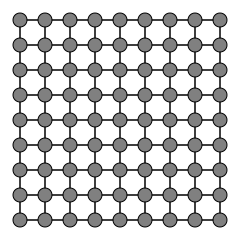

In [7]:
image = visualize_graph(adjacency, position, width=200, height=200)
SVG(image)

## To do

* Cluster the graph by Louvain and return the corresponding modularity.
* Try to shuffle the nodes and observe the results.
* Find a better clustering than Louvain in terms of modularity. Comment your results.

## Answers

Louvain and Leiden are two algorithms that finds clustering by maximizing modularity. While Louvain can get stuck in local maxima, Louvain is more robust avoiding local maxima. The Louvain algorithm yields a modularity of 0.622 while Leiden yields a modularity of 0.625. The results are quite close.

Instead of using the algorithms we tried a uniform clustering, agreagating nodes 9 by 9. This returned a higher modularity than using both cited algorithms of 0.638

We also noticed that when shuffling the adjacency matrix and applying both algorithms in the shuffled graph we got a better modularity result of 0.631 for both Louvain and Leiden.

In [8]:
louvain = Louvain()

In [9]:
labels = louvain.fit_predict(adjacency)

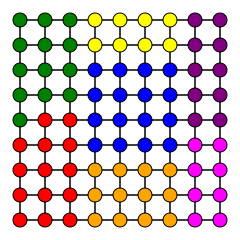

In [10]:
image = visualize_graph(adjacency, position, labels=labels, width=200, height=200)
SVG(image)

In [11]:
get_modularity(adjacency, labels)

np.float64(0.6220341435185185)

In [12]:
# Shuffle the nodes
n = adjacency.shape[0]
perm = np.random.permutation(n)
adj_shuffle = adjacency[perm, :][:, perm]
print(adj_shuffle.shape, adjacency.shape)

(81, 81) (81, 81)


In [13]:
# Apply Louvain Algorithm to the shuffled adjacency matrix
labels_2 = louvain.fit_predict(adj_shuffle)

image_2 = visualize_graph(adj_shuffle, position[perm], labels=labels_2, width=200, height=200)
SVG(image_2)

print(get_modularity(adj_shuffle, labels_2))

0.6167052469135803


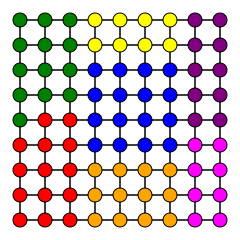

In [14]:
# Leiden Algorithm
leiden = Leiden()
labels_leiden = leiden.fit_predict(adjacency)

image_leiden = visualize_graph(adjacency, position, labels=labels_leiden, width=200, height=200)
SVG(image_leiden)

In [15]:
get_modularity(adjacency, labels_leiden)

np.float64(0.6220341435185185)

In [16]:
# Leiden with shuffle
labels_leiden_2 = leiden.fit_predict(adj_shuffle)

image_leiden_2 = visualize_graph(adj_shuffle, position[perm], labels=labels_leiden_2, width=200, height=200)
SVG(image_leiden_2)
print(get_modularity(adj_shuffle, labels_leiden_2))

0.6157889660493827


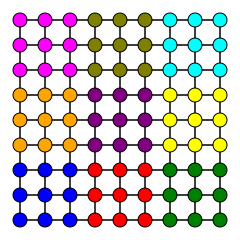

In [17]:
# Uniform Clustering
n = adjacency.shape[0]
labels = np.array([((i % 9) // 3) * 3 + (i // 9) // 3 for i in range(n)])
image = visualize_graph(adjacency, position, labels=labels, width=200, height=200)
SVG(image)

In [18]:
get_modularity(adjacency, labels)

np.float64(0.638454861111111)

## Karate Club


The [karate club graph](https://en.wikipedia.org/wiki/Zachary%27s_karate_club) provides ground-truth clusters.

In [19]:
dataset = karate_club(metadata=True)

In [20]:
adjacency = dataset.adjacency
position = dataset.position
labels_true = dataset.labels

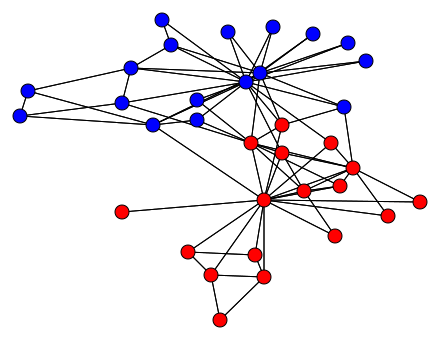

In [21]:
image = visualize_graph(adjacency, position, labels=labels_true)
SVG(image)

## To do

* Cluster the graph by Louvain and display the labels. Give the modularity.
* Compare with the modularity obtained with the ground-truth labels and comment the results.
* Display the aggregate graph after clustering by Louvain (check this [tutorial](https://scikit-network.readthedocs.io/en/latest/tutorials/clustering/louvain.html)).
* Adapt the resolution to get 2 clusters. Compare with the ground-truth and comment the results.

## Answers

* Modularity after clustering with Louvain -> 0.4188

* Louvain yields a modularity of 0.4188 while ground-truth labels yields a modularity of 0.3582. Louvain gives a different result than the ground truth but has higher modularity, this is due to the fact that Louvain's criterion is improving modularity while clustering.

* By lowering Louvain’s resolution parameter to 0.5, the algorithm produces exactly two communities, closely matching the ground-truth split. Only a few nodes end up in the wrong cluster compared to the true labels, making this two-cluster solution much more faithful than the default (resolution = 1) partitioning.

In [22]:
louvain = Louvain()

In [23]:
labels = louvain.fit_predict(adjacency)

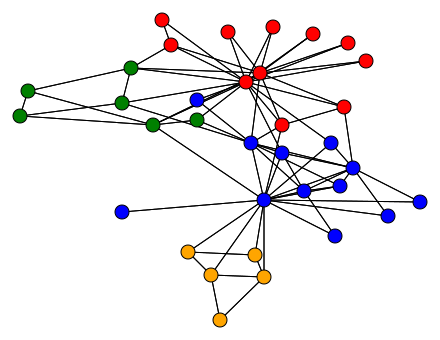

In [24]:
image = visualize_graph(adjacency, position, labels=labels)
SVG(image)

In [25]:
# Compare the labels returned by Louvain with the ground truth labels
print("Louvain Modularity", get_modularity(adjacency, labels))
print("Ground-truth labels Modularity", get_modularity(adjacency, labels_true))

Louvain Modularity 0.4188034188034188
Ground-truth labels Modularity 0.3582347140039448


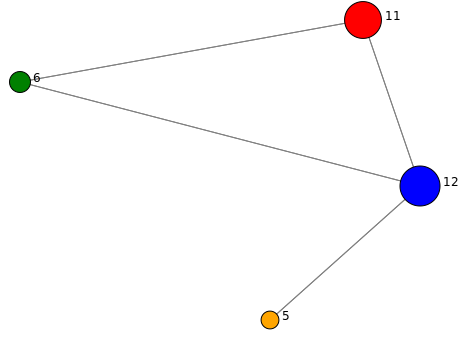

In [26]:
# Aggregate graph (one node per cluster)
adjacency_aggregate = louvain.aggregate_
average = normalize(get_membership(labels).T)
position_aggregate = average.dot(position)
labels_unique, counts = np.unique(labels, return_counts=True)
image = visualize_graph(adjacency_aggregate, position_aggregate, counts, labels=labels_unique,
                  display_node_weight=True, node_weights=counts)
SVG(image)

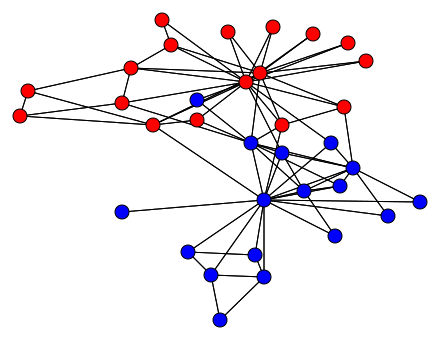

In [27]:
louvain = Louvain(resolution=0.5)
labels = louvain.fit_predict(adjacency)
image = visualize_graph(adjacency, position, labels=labels)
SVG(image)

In [28]:
get_modularity(adjacency, labels)

np.float64(0.3717948717948718)

## Openflights


In [29]:
dataset = openflights

In [30]:
adjacency = dataset.adjacency
position = dataset.position
names = dataset.names

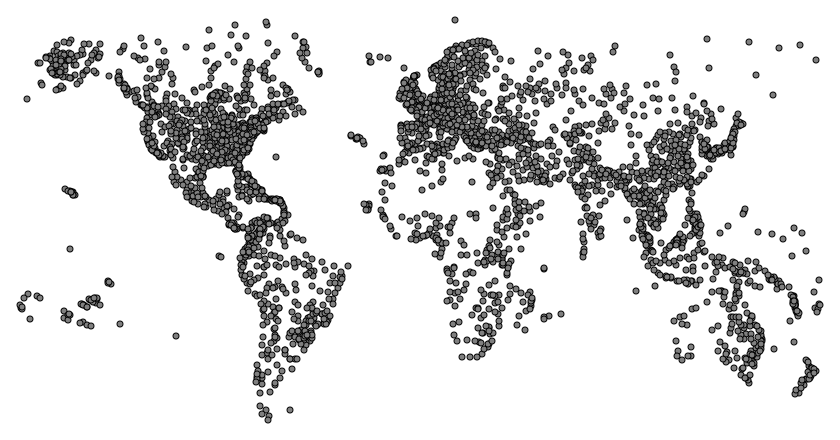

In [31]:
image = visualize_graph(adjacency, position, width=800, height=400, node_size=3, display_edges=False)
SVG(image)

## To do

* Display the same world map with the clusters found by Louvain (resolution 1).
* How many clusters are there?
* What is the Simpson index of this clustering? How to interpret this result?
* List the top airport of each cluster in number of flights.
* Display the aggregate graph. Name each cluster by its top airport and display the total traffic of each cluster by the node size.
* Display the same graph restricted to clusters with at least 100 nodes.
* What is the cluster with the highest traffic?

## Answers:

* There are 30 clusters.

* The Simpson index of the clustering is 0.207. As the Simpson index give us how dense is the graph clusters is. As our obtained result is closer to 0 than to 1, the clustering is more sparse, low concentrated distribution.

* The cluster with the highest traffic is Amsterdam Airport Schiphol.



In [32]:
louvain = Louvain(resolution=1)
labels = louvain.fit_predict(adjacency)

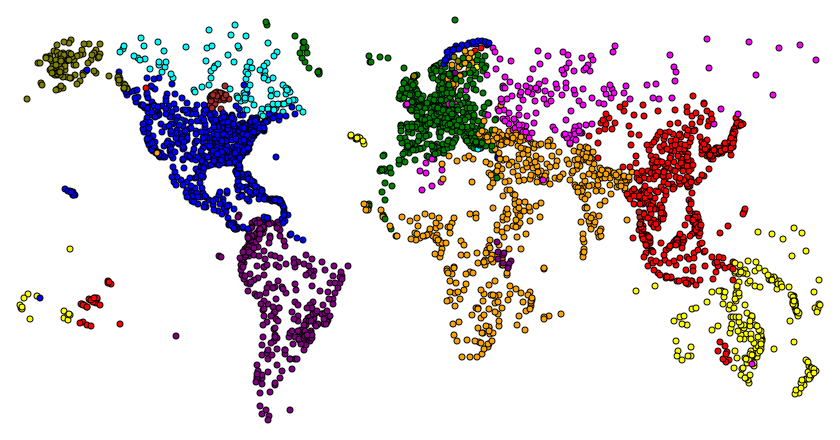

In [33]:
image = visualize_graph(adjacency, position, labels=labels, width=800, height=400, node_size=3, display_edges=False)
SVG(image)

In [34]:
print(f'there are {np.unique(labels).size} clusters')

there are 30 clusters


In [35]:
def simpson_index(labels, adjacency):
    degrees = get_degrees(adjacency)
    label_degree_sum = {}

    for label in np.unique(labels):
        label_degree_sum[label] = degrees[labels == label].sum()

    v = degrees.sum()
    p = np.array([vk / v for vk in label_degree_sum.values()])

    S = np.sum(p ** 2)

    return S

In [36]:
print(f'Simpson index: {simpson_index(labels,adjacency)}')

Simpson index: 0.2071594223825969


In [37]:
# top airport of each cluster in number of flights

weights = get_weights(adjacency)

top_airports = []

for label in np.unique(labels):
    # get the global IDs of nodes in this cluster
    cluster = np.where(labels == label)[0]
    # extract their weights
    cluster_weights = weights[cluster]
    # find the best local position within cluster_weights
    local_best = top_k(cluster_weights, 1)[0]
    # map that back to the global node ID
    global_best = cluster[local_best]
    top_airports.append(global_best)

for idx in top_airports:
    print(names[idx])


Hartsfield Jackson Atlanta International Airport
Beijing Capital International Airport
Amsterdam Airport Schiphol
Atatürk International Airport
Guarulhos - Governador André Franco Montoro International Airport
Sydney Kingsford Smith International Airport
Domodedovo International Airport
Ted Stevens Anchorage International Airport
Quebec Jean Lesage International Airport
Sioux Lookout Airport
Trondheim Airport Værnes
Faa'a International Airport
Godthaab / Nuuk Airport
Stockholm-Bromma Airport
Nairobi Wilson Airport
João Paulo II Airport
Touat Cheikh Sidi Mohamed Belkebir Airport
Kirkwall Airport
Sitia Airport
Myeik Airport
Eilat Airport
Ivalo Airport
Lycksele Airport
Pori Airport
Örebro Airport
Jyvaskyla Airport
St. Mary's Airport
Vilhelmina Airport
Cheyenne Regional Jerry Olson Field
Golfito Airport


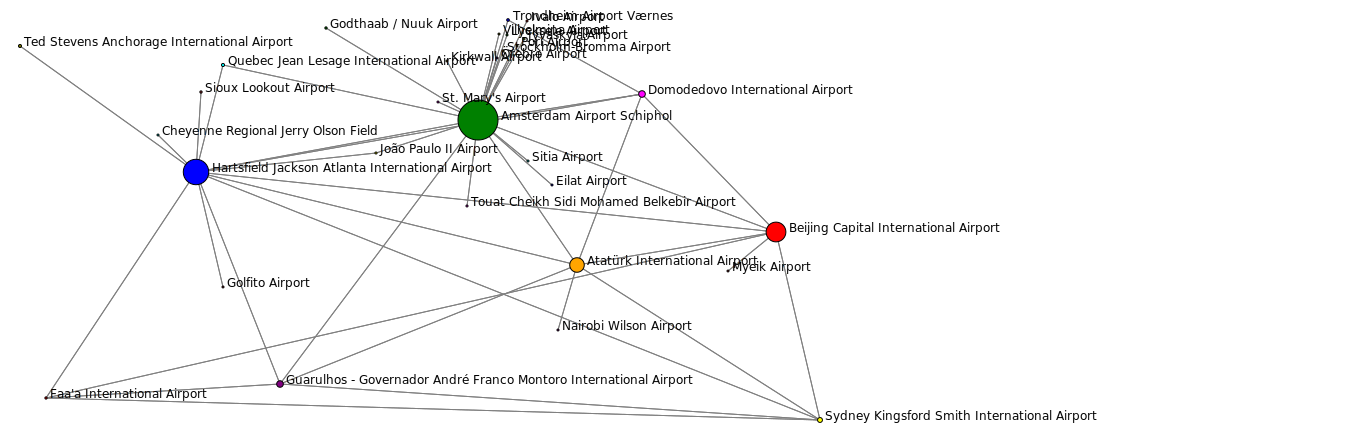

In [38]:
# Aggregate graph (one node per cluster)
adjacency_aggregate = louvain.aggregate_
average = normalize(get_membership(labels).T)
position_aggregate = average.dot(position)
labels_unique, counts = np.unique(labels, return_counts=True)
image = visualize_graph(adjacency_aggregate, position_aggregate, width=800, height=400,
                        names=names[top_airports], labels=labels_unique,
                  display_node_weight=True)
SVG(image)

In [39]:
# clusters with at least 100 nodes
unique_labels = np.unique(labels)
counts = np.array([np.sum(labels == l) for l in unique_labels])

# Select clusters with at least 100 nodes
large_mask = counts >= 100

# Restrict the aggregate adjacency matrix
adjacency_agg_large = adjacency_aggregate[large_mask][:, large_mask]


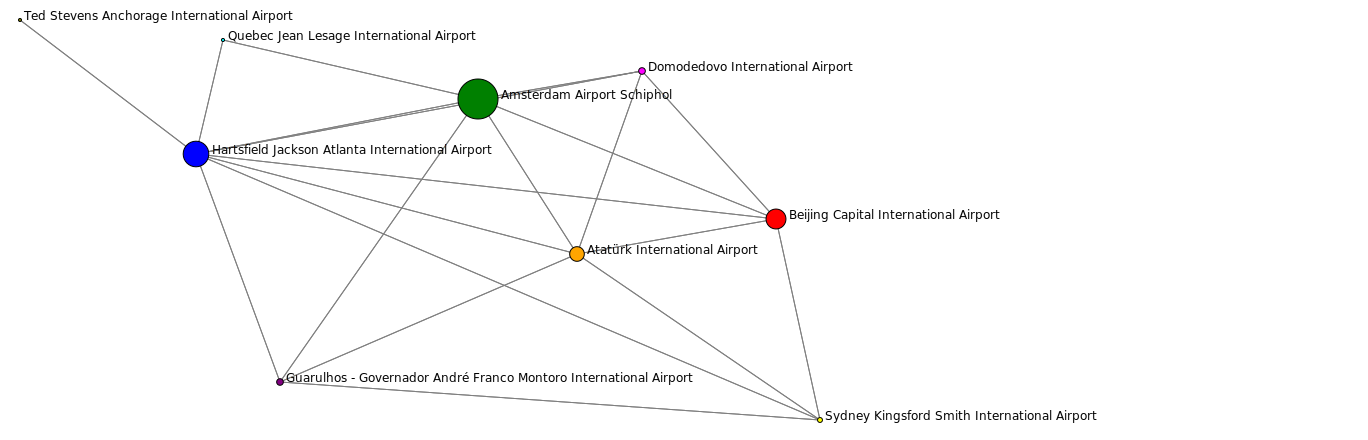

In [40]:
image = visualize_graph(adjacency_aggregate[large_mask][:, large_mask],
                        position_aggregate[large_mask],
                        names=names[top_airports][large_mask], labels=labels_unique[large_mask],
                        width=800, height=400,
                  display_node_weight=True)
SVG(image)

In [41]:
traffics = get_weights(adjacency_aggregate)
names[top_airports][large_mask][np.argmax(traffics[large_mask])]

np.str_('Amsterdam Airport Schiphol')

## Wikipedia Vitals

In [42]:
graph = wikivitals

In [43]:
adjacency = graph.adjacency
names = graph.names

## To do

* Cluster the graph by Louvain (resolution 1).
* List the top-5 pages of each cluster in terms of Personalized PageRank.
* Display the aggregate graph with the cluster volumes and the name of the top page of each cluster.
* Display the same graph restricted to clusters with at least 100 nodes.
* Among these clusters, which is the strongest? Interpret the result.
* Repeat the same experiments at resolution 2.

## Answer:

* The strongest cluster for resolution 1 is the cluster that contains Physics. This means that the random walker has the highest probability of continuing at that same cluster after walking one time.

* The experiment for (resolution = 2) returns more clusters and the result for the strongest cluster changes to Aristotle.

In [44]:
# Cluster the graph by Louvain
louvain = Louvain(resolution=1)
labels = louvain.fit_predict(adjacency)

In [45]:
# List top 5 pages of each cluster in terms of Personalized PageRank
pagerank = PageRank()

top_pages = []
for l in np.unique(labels):
  scores = pagerank.fit_predict(adjacency, weights = labels == l)
  scores *= labels == l
  top_pages.append(names[top_k(scores, 1)])
  print(names[top_k(scores, 5)])

['Physics' 'Hydrogen' 'Oxygen' 'Kelvin' 'Albert Einstein']
['Taxonomy (biology)' 'Animal' 'Plant' 'Protein' 'Species']
['Latin' 'World War I' 'Roman Empire' 'Middle Ages' 'Greek language']
['Christianity' 'Aristotle' 'Catholic Church' 'Plato'
 'Age of Enlightenment']
['United States' 'World War II' 'Geographic coordinate system'
 'United Kingdom' 'France']
['China' 'India' 'Buddhism' 'Islam' 'Chinese language']
['The New York Times' 'New York City' 'Time (magazine)' 'BBC'
 'The Washington Post']
['Earth' 'Atlantic Ocean' 'Europe' 'Drainage basin' 'Pacific Ocean']
['Handbag' 'Hat' 'Veil' 'Uniform' 'Clothing']


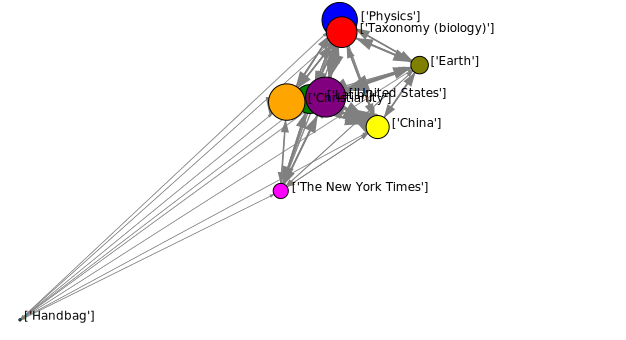

In [46]:
# Display the aggregate graph with the cluster volumes and the name of the top page of each cluster.
adjacency_aggregate = louvain.aggregate_

image = visualize_graph(adjacency_aggregate, names=top_pages, display_node_weight=True, display_edge_weight=True, labels=np.unique(labels))
SVG(image)

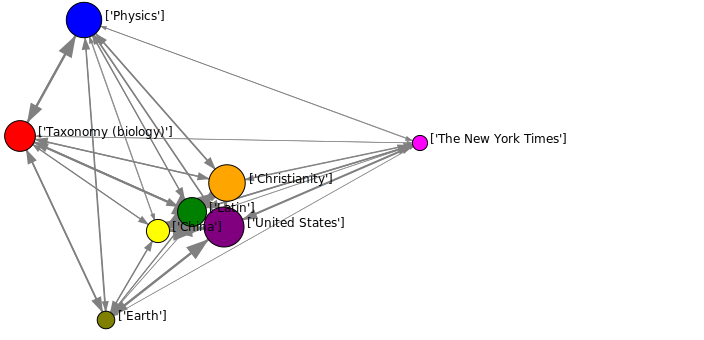

In [47]:
# Display the same graph restricted to clusters with at least 100 nodes.

# Compute the size of each cluster
unique_labels = np.unique(labels)
counts = np.array([np.sum(labels == l) for l in unique_labels])

# Select clusters with at least 100 nodes
large_mask = counts >= 100

# Restrict the aggregate adjacency matrix
adjacency_agg_large = adjacency_aggregate[large_mask][:, large_mask]

# Filter the top page names and labels
names_large = [top_pages[i] for i, keep in enumerate(large_mask) if keep]
labels_large = unique_labels[large_mask]

# Visualize the restricted aggregate graph
image = visualize_graph(
    adjacency_agg_large,
    names=names_large,
    display_node_weight=True,
    display_edge_weight=True,
    labels=labels_large
)
SVG(image)

In [48]:
strengths = adjacency_aggregate.diagonal()/get_weights(adjacency_aggregate)
print("Strongest:", top_pages[np.argmax(strengths)])

Strongest: ['Physics']


In [49]:
# Cluster the graph by Louvain
louvain = Louvain(resolution=2)
labels = louvain.fit_predict(adjacency)

# List top 5 pages of each cluster in terms of Personalized PageRank
pagerank = PageRank()

top_pages = []
for l in np.unique(labels):
  scores = pagerank.fit_predict(adjacency, weights = labels == l)
  scores *= labels == l
  top_pages.append(names[top_k(scores, 1)])
  print(names[top_k(scores, 5)])

['Taxonomy (biology)' 'Animal' 'Chordate' 'Permian' 'Cambrian']
['The New York Times' 'BBC' 'Time (magazine)' 'The Washington Post'
 'Library of Congress']
['Physics' 'Albert Einstein' 'Isaac Newton' 'Kelvin' 'Electron']
['World Health Organization' 'Medical diagnosis' 'Cancer'
 'Central nervous system' 'Immune system']
['Jewellery' 'Wood' 'Industrial Revolution' 'Axe' 'Agriculture']
['Real number' 'Function (mathematics)' 'Complex number'
 'Set (mathematics)' 'Mathematical analysis']
['Aristotle' 'Plato' 'Immanuel Kant' 'David Hume' 'Age of Enlightenment']
['Christianity' 'Catholic Church' 'Buddhism' 'Islam' 'Hinduism']
['Ottoman Empire' 'Roman Empire' 'Byzantine Empire' 'Iran'
 'Persian language']
['Paris' 'London' 'Modernism' 'Renaissance' 'Rome']
['World War II' 'World War I' 'Soviet Union' 'Cold War' 'United Nations']
['China' 'Chinese language' 'Japan' 'Ming dynasty' 'Qing dynasty']
['United Kingdom' 'France' 'Egypt' 'South Africa' 'Canada']
['Earth' 'NASA' 'Plate tectonics' 'Moo

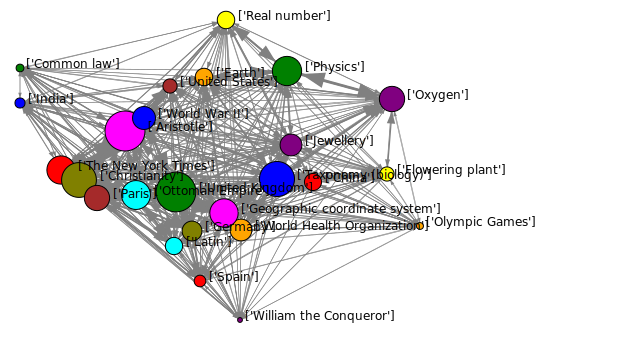

In [50]:
# Display the aggregate graph with the cluster volumes and the name of the top page of each cluster.
adjacency_aggregate = louvain.aggregate_

image = visualize_graph(adjacency_aggregate, names=top_pages, display_node_weight=True, display_edge_weight=True, labels=np.unique(labels))
SVG(image)

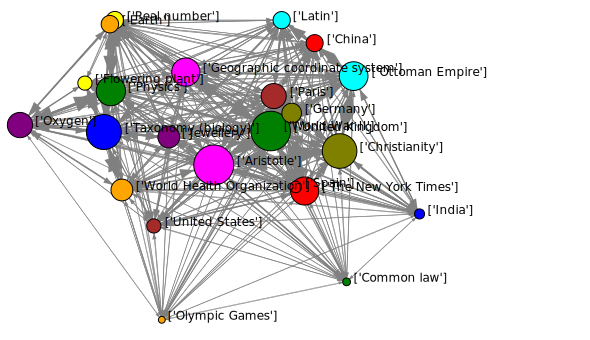

In [51]:
# Display the same graph restricted to clusters with at least 100 nodes.

# Compute the size of each cluster
unique_labels = np.unique(labels)
counts = np.array([np.sum(labels == l) for l in unique_labels])

# Select clusters with at least 100 nodes
large_mask = counts >= 100

# Restrict the aggregate adjacency matrix
adjacency_agg_large = adjacency_aggregate[large_mask][:, large_mask]

# Filter the top page names and labels
names_large = [top_pages[i] for i, keep in enumerate(large_mask) if keep]
labels_large = unique_labels[large_mask]

# Visualize the restricted aggregate graph
image = visualize_graph(
    adjacency_agg_large,
    names=names_large,
    display_node_weight=True,
    display_edge_weight=True,
    labels=labels_large
)
SVG(image)

In [52]:
strengths = adjacency_aggregate.diagonal() / get_weights(adjacency_aggregate)
print("Strongest:", top_pages[np.argmax(strengths)])

Strongest: ['Oxygen']


## 3. Bipartite graphs

## Cinema

In [53]:
dataset = cinema

In [54]:
biadjacency = dataset.biadjacency
movies = dataset.names_row
actors = dataset.names_col

## To do

* Cluster the graph by Louvain (resolution 1).
* List the 10 largest clusters and display the names of the top-3 actors and top-3 movies of these cluster in terms of Personalized PageRank.

In [55]:
# Cluster the graph by Louvain with resolution=1
louvain  = Louvain(resolution=1)
labels = louvain.fit_predict(biadjacency)

In [56]:
# Get the labels for row and column
labels_row = louvain.labels_row_
labels_col = louvain.labels_col_

In [57]:
# Use PageRank and display the top 3 movies and actors of the 10 largests clusters
pagerank = PageRank()
for label in np.unique(labels_row)[:10]:
    print(f"Cluster {label}")
    pagerank.fit(biadjacency, weights_row=labels_row == label, weights_col=labels_col == label)

    scores_row = pagerank.scores_row_ * (labels_row == label)
    scores_col = pagerank.scores_col_ * (labels_col == label)

    print("Top 3 Movies:",movies[top_k(scores_row, 3)])
    print("Top 3 Actors:",actors[top_k(scores_col,3)])
    print("#####################################################")



Cluster 0
Top 3 Movies: ['The Walking Dead (TV series)' 'Arrow (TV series)'
 'House of Cards (U.S. TV series)']
Top 3 Actors: ['Eric Roberts' 'Donald Sutherland' 'Harvey Keitel']
#####################################################
Cluster 1
Top 3 Movies: ['Paramount on Parade' 'Ziegfeld Follies' 'Mourning Becomes Electra']
Top 3 Actors: ['Harry Carey' 'Blanche Sweet' 'Roy Rogers']
#####################################################
Cluster 2
Top 3 Movies: ['Suyamvaram' 'Kerala Cafe' 'Paalayam']
Top 3 Actors: ['Prem Nazir' 'Jagathy Sreekumar' 'Adoor Bhasi']
#####################################################
Cluster 3
Top 3 Movies: ['Kaamelott' 'Research unit' 'Hero Corp']
Top 3 Actors: ['Louis de Funès' 'Isabelle Huppert' 'Marcello Mastroianni']
#####################################################
Cluster 4
Top 3 Movies: ['The Devil Rides Out' "What's Up Superdoc!" 'Unforgotten']
Top 3 Actors: ['Christopher Lee' 'Stewart Rome' 'John Stuart']
#####################################